## Swarm A/B conjunction points

This demo notebooks shows Swarm A/B conjunction points rerieval from the VirES server



In [1]:
SERVER_URL = "https://staging.viresdisc.vires.services/ows"

COLLECTION = "SW_OPER_MOD{spacecraft}_SC_1B"
#COLLECTION = "SW_OPER_MAG{spacecraft}_LR_1B"

In [2]:
! pip install --upgrade --no-deps --force-reinstall 'git+https://github.com/ESA-VirES/VirES-Python-Client@swarm_ab_conjunctions#egg=viresclient'

  Cloning https://github.com/ESA-VirES/VirES-Python-Client (to revision swarm_ab_conjunctions) to /tmp/pip-install-uxbu3jhd/viresclient_9e5d32e80f06456a9503a6232e46b0e3
  Running command git clone -q https://github.com/ESA-VirES/VirES-Python-Client /tmp/pip-install-uxbu3jhd/viresclient_9e5d32e80f06456a9503a6232e46b0e3
  Running command git checkout -b swarm_ab_conjunctions --track origin/swarm_ab_conjunctions
  Switched to a new branch 'swarm_ab_conjunctions'
  Branch 'swarm_ab_conjunctions' set up to track remote branch 'swarm_ab_conjunctions' from 'origin'.
  Resolved https://github.com/ESA-VirES/VirES-Python-Client to commit eda8eff80d46ca05107081cf85e08d71ea17675c
  Created wheel for viresclient: filename=viresclient-0.9.1_dev_conjunctions-py3-none-any.whl size=75216 sha256=6ba4aba6e2184263d5a41dbe8dc468cab6bbaa5698f7f46ed902089189817dbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-y72jqgsy/wheels/f3/c5/42/69d1ef320f075cb169b11af9af96eff674cbf78974e0480fb2
Failed to build vire

In [3]:
from viresclient import SwarmRequest

def get_swarm_ab_conjunctions(start_time, end_time, threshold=1.0):
    """ Retrieve Swarm-A/B conjunctions times. """
    print(f"Retrieving Swarm A/B conjunction times from {start_time} to {end_time}, angular separation < {threshold} deg ... ")
    request = SwarmRequest(SERVER_URL)
    return request.get_conjunctions(
        start_time=start_time,
        end_time=end_time,
        threshold=threshold,
    ).as_xarray()
    
def get_swarm_orbit(spacecraft, start_time, end_time, asynchronous=False, **opts):
    "Retrieve Swarm-A/B locations for the given time-interval from the VirES server."
    print(f"Retrieving Swarm {spacecraft} orbit from {start_time} to {end_time} ... ")
    request = SwarmRequest(SERVER_URL)
    request.set_collection(COLLECTION.format(spacecraft=spacecraft))
    request.set_products(measurements=[], **opts)
    return request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=asynchronous,
    ).as_xarray()

def get_swarm_ab_orbits(start_time, end_time, asynchronous=False, **opts):
    "Retrieve Swarm-A/B locations for the given time-interval from the VirES server."
    return (
        get_swarm_orbit("A", start_time, end_time, asynchronous=asynchronous, **opts),
        get_swarm_orbit("B", start_time, end_time, asynchronous=asynchronous, **opts),
    )

In [4]:
from numpy import degrees, stack, ones, arccos
from eoxmagmod import convert, GEOCENTRIC_CARTESIAN, GEOCENTRIC_SPHERICAL

def get_angular_distance(latlon1, latlon2):
    """ Calculate angular distance in degrees from two spherical (latitude, longitude) coordinates in degrees. """
    xyz1 = convert(
        stack((latlon1[..., 0], latlon1[..., 1], ones(latlon1.shape[:-1])), axis=-1),
        GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
    )    
    xyz2 = convert(
        stack((latlon2[..., 0], latlon2[..., 1], ones(latlon2.shape[:-1])), axis=-1),
        GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
    )
    return degrees(arccos((xyz1 * xyz2).sum(axis=-1)))

/opt/conda/lib/python3.8/site-packages/spacepy/time.py:2294: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [5]:
from collections import namedtuple
from numpy import timedelta64, searchsorted
from numpy.testing import assert_equal


ONE_SEC = timedelta64(1, 's')
HALF_SEC = timedelta64(500, 'ms')


class TimeRange(namedtuple('TimeRange', ['start', 'end'])):
    """ Time range auxiliary class. """
    
    @property
    def is_empty(self):
        return self.start >= self.end
    
    def trim_start(self, new_start):
        return TimeRange(new_start, self.end)


def extract_overlapping_data(data_a, data_b):
    """ Extract overlaping uninterupted data segments. """
    timestamp_a, position_a = extract_orbit(data_a)
    timestamp_b, position_b = extract_orbit(data_b)
    
    time_ranges_a = generate_time_ranges(timestamp_a)
    time_ranges_b = generate_time_ranges(timestamp_b)
    
    for time_range in generate_time_range_overlaps(time_ranges_a, time_ranges_b):
        slice_a = get_temporal_slice(timestamp_a, *time_range)
        slice_b = get_temporal_slice(timestamp_b, *time_range)
        assert_equal(timestamp_a[slice_a], timestamp_b[slice_b])
        yield timestamp_a[slice_a], position_a[slice_a], position_b[slice_b]
        

def get_temporal_slice(timestamps, start_time, end_time):
    """ Get Pyhton slice object selecting sorted timestamps within the given time range. """
    start, end = searchsorted(timestamps, (start_time, end_time), side='left')
    return slice(start, end)


def generate_time_ranges(timestamp):
    """ Get time ranges of continuous data segments assuming 1s data sampling. """    
    timestamp = round_time_to_seconds(timestamp)
    if timestamp.size == 0:
        return
    dt = timestamp[1:] - timestamp[:-1]
    assert dt.size == 0 or dt.min() >= ONE_SEC
    idx_start = 0
    for idx_end in (dt > ONE_SEC).nonzero()[0]:
        yield TimeRange(timestamp[idx_start], timestamp[idx_end] + ONE_SEC)
        idx_start = idx_end + 1
    yield TimeRange(timestamp[idx_start], timestamp[-1] + ONE_SEC)

    
def generate_time_range_overlaps(ranges_a, ranges_b):
    """ Generage overlaping time ranges. """
    
    def _get_next_range(range_iterator):
        for range_ in range_iterator:
            if not range_.is_empty:
                return range_
        return None

    range_a = _get_next_range(ranges_a)
    range_b = _get_next_range(ranges_b)
    
    while range_a and range_b:

        if range_a.start < range_b.start:
            range_a = range_a.trim_start(range_b.start)
        elif range_b.start < range_a.start:
            range_a = range_a.trim_start(range_b.start)
        else: # range_a.start == range_b.start
            overlap = TimeRange(range_a.start, min(range_a.end, range_b.end))
            yield overlap
            range_a = range_a.trim_start(overlap.end)
            range_b = range_b.trim_start(overlap.end)

        if range_a.is_empty:
            range_a = _get_next_range(ranges_a)
        if range_b.is_empty:
            range_b = _get_next_range(ranges_b)

        
def extract_orbit(data):
    """ Extract spacecraft times and position in geocentric sperical coordinates from the VirES response. """
    timestamp = data['Timestamp'].values
    position = stack((
        data['Latitude'].values,
        data['Longitude'].values,
        data['Radius'].values
    ), axis=-1)
    return timestamp, position


def round_time_to_seconds(timestamp):
    """Round times to whole seconds."""
    return (timestamp + HALF_SEC).astype('datetime64[s]') 

In [6]:
from matplotlib.pyplot import figure, subplot, show

def split_longitudes(longs):
    start = None
    for idx in (abs(longs[1:] - longs[:-1]) > 180).nonzero()[0]:
        end = idx + 1
        yield slice(start, end)
        start = end
    end = None
    yield slice(start, end)

def plot_conjunctions(orbit_a, orbit_b, conjunctions_ab, conjunctions_ab_all):
    fig = figure(figsize=(32, 24), dpi=100)

    ax = subplot(4, 1, 1)
    ax.set_ylim([-90, 90])
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax.grid()
    ax.set_ylabel('Latitude / deg')
    h_a, = ax.plot(orbit_a['Timestamp'], orbit_a['Latitude'], color='tab:blue')
    h_b, = ax.plot(orbit_b['Timestamp'], orbit_b['Latitude'], color='tab:green')

    ymin, ymax = ax.get_ylim(); ax.set_ylim([ymin, ymax])
    for time in conjunctions_ab['Timestamp'].values:
        h_c, = ax.plot([time, time], [ymin, ymax], 'r:')

    xmin, xmax = ax.get_xlim()

    ax.legend([h_a, h_b, h_c], ['Swarm A', 'Swarm B', 'A/B conjunction'])

    ax = subplot(4, 1, 2)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([-180, 180])
    ax.set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    ax.grid()
    ax.set_ylabel('Longitude / deg')
    for slice_ in split_longitudes(orbit_a['Longitude'].values):
        h_a, = ax.plot(orbit_a['Timestamp'].values[slice_], orbit_a['Longitude'].values[slice_], color='tab:blue')
    for slice_ in split_longitudes(orbit_b['Longitude'].values):
        h_b, = ax.plot(orbit_b['Timestamp'].values[slice_], orbit_b['Longitude'].values[slice_], color='tab:green')

    ymin, ymax = ax.get_ylim()
    for time in conjunctions_ab['Timestamp'].values:
        h_c, = ax.plot([time, time], [ymin, ymax], 'r:')

    ax.legend([h_a, h_b, h_c], ['Swarm A', 'Swarm B', 'A/B conjunction'])


    ax = subplot(4, 1, 3)

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([0, 180])
    ax.grid()
    ax.set_ylabel('Angular Separation / deg')

    for timestamp, position_a, position_b in extract_overlapping_data(orbit_a, orbit_b):
        angular_distance = get_angular_distance(position_a, position_b)
        h_ang, = ax.plot(timestamp, angular_distance, '-', ms=0.1, color='tab:gray')

    h_min, = ax.plot(conjunctions_ab_all['Timestamp'], conjunctions_ab_all['AngularSeparation'], '.', color='tab:blue')
    h_cnj, = ax.plot(conjunctions_ab['Timestamp'], conjunctions_ab['AngularSeparation'], 'ro')

    ymin, ymax = ax.get_ylim()
    for time in conjunctions_ab['Timestamp'].values:
        h_c, = ax.plot([time, time], [ymin, ymax], 'r:')

    ax.legend([
        h_ang,
        h_min,
        h_cnj,
    ], [
        'Swarm A/B ang.separation',
        'Swarm A/B nearest point',
        'Swarm A/B conjunction',
    ])

    ax = subplot(4, 1, 4)

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([0, 5])
    ax.grid()
    ax.set_ylabel('Angular Separation / deg')

    for timestamp, position_a, position_b in extract_overlapping_data(orbit_a, orbit_b):
        angular_distance = get_angular_distance(position_a, position_b)
        h_ang, = ax.plot(timestamp, angular_distance, '-', ms=0.1, color='tab:gray')

    h_min, = ax.plot(conjunctions_ab_all['Timestamp'], conjunctions_ab_all['AngularSeparation'], '.', color='tab:blue')
    h_cnj, = ax.plot(conjunctions_ab['Timestamp'], conjunctions_ab['AngularSeparation'], 'ro')

    ymin, ymax = ax.get_ylim()
    for time in conjunctions_ab['Timestamp'].values:
        h_c, = ax.plot([time, time], [ymin, ymax], 'r:')

    ax.legend([
        h_ang,
        h_min,
        h_cnj,
    ], [
        'Swarm A/B ang.separation',
        'Swarm A/B nearest point',
        'Swarm A/B conjunction',
    ])


Retrieving Swarm A/B conjunction times from 2021-09-12T12:00 to 2021-09-14, angular separation < 1.0 deg ... 


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.02MB)

Retrieving Swarm A/B conjunction times from 2021-09-12T12:00 to 2021-09-14, angular separation < 180.0 deg ... 


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.02MB)

Retrieving Swarm A orbit from 2021-09-12T12:00 to 2021-09-14 ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (4.281MB)

Retrieving Swarm B orbit from 2021-09-12T12:00 to 2021-09-14 ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (4.281MB)

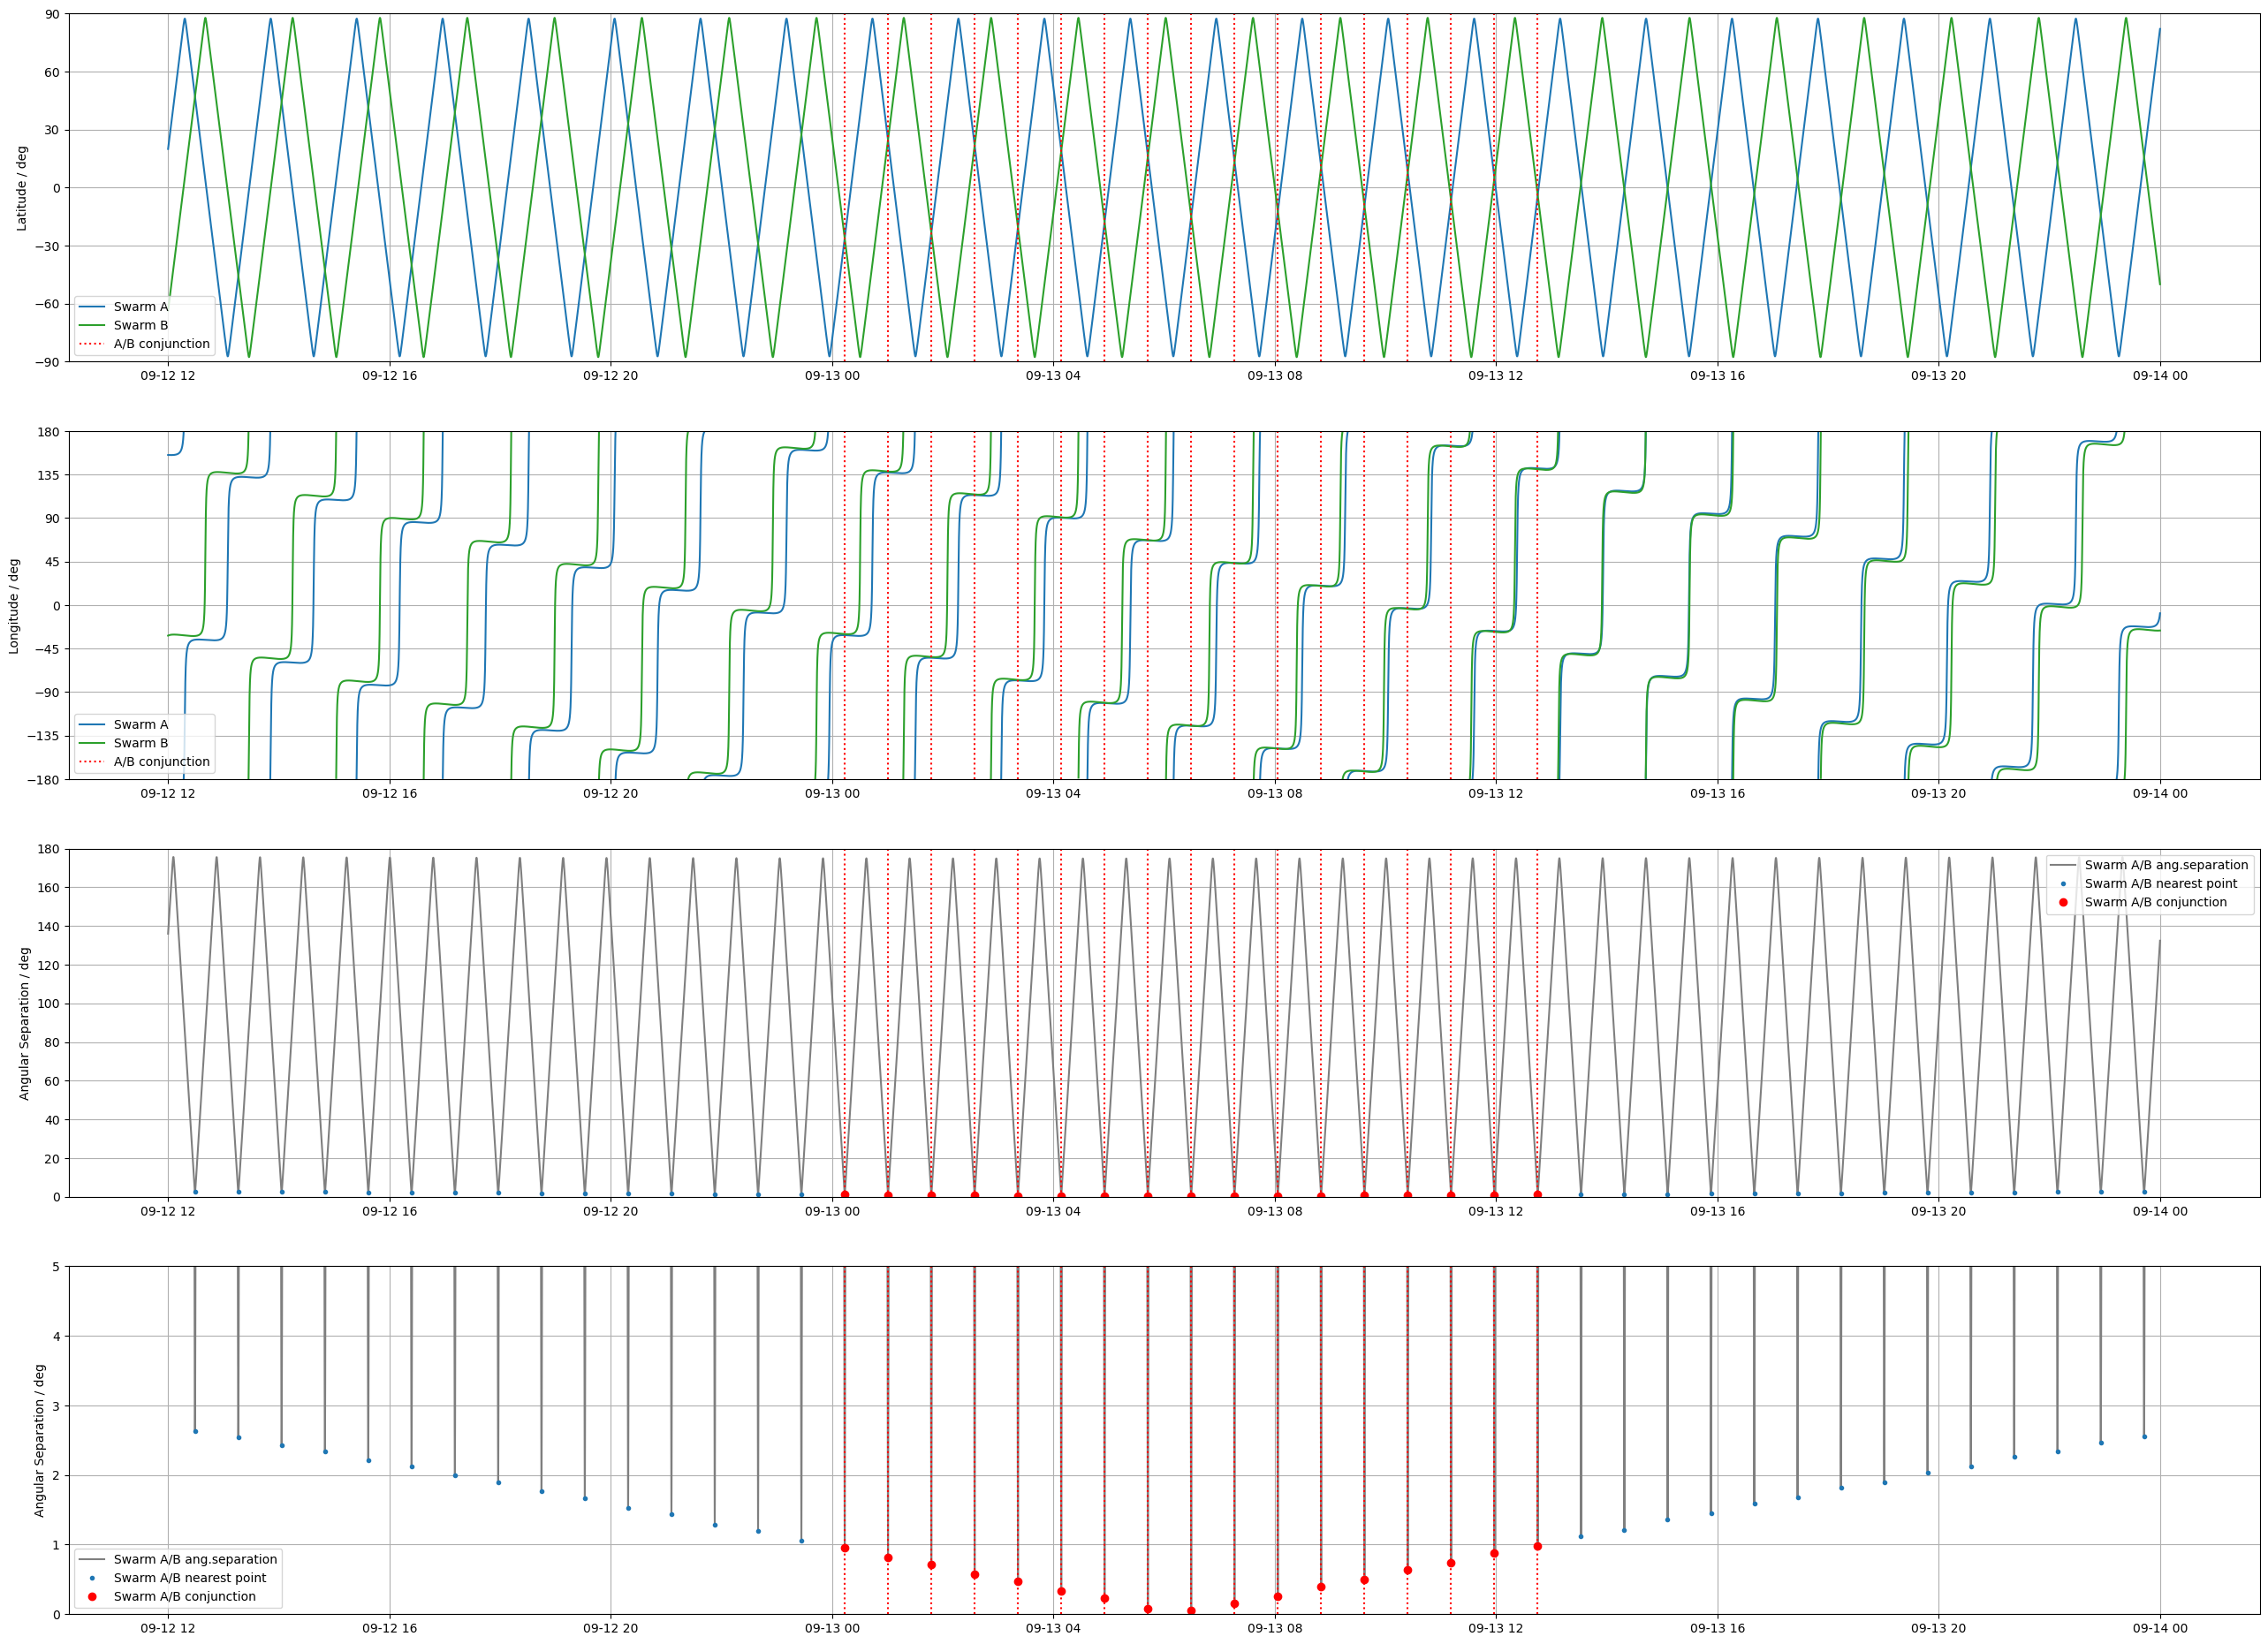

In [7]:
start_time, end_time = "2021-09-12T12:00", "2021-09-14"

conjunctions_ab = get_swarm_ab_conjunctions(start_time, end_time)
conjunctions_ab_all = get_swarm_ab_conjunctions(start_time, end_time, threshold=180.0)
orbit_a, orbit_b = get_swarm_ab_orbits(start_time, end_time, asynchronous=True)

plot_conjunctions(orbit_a, orbit_b, conjunctions_ab, conjunctions_ab_all)


Retrieving Swarm A/B conjunction times from 2016-09-12T00:00 to 2016-09-13T12:00, angular separation < 1.0 deg ... 


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.02MB)

Retrieving Swarm A/B conjunction times from 2016-09-12T00:00 to 2016-09-13T12:00, angular separation < 180.0 deg ... 


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.02MB)

Retrieving Swarm A orbit from 2016-09-12T00:00 to 2016-09-13T12:00 ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (4.281MB)

Retrieving Swarm B orbit from 2016-09-12T00:00 to 2016-09-13T12:00 ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (4.281MB)

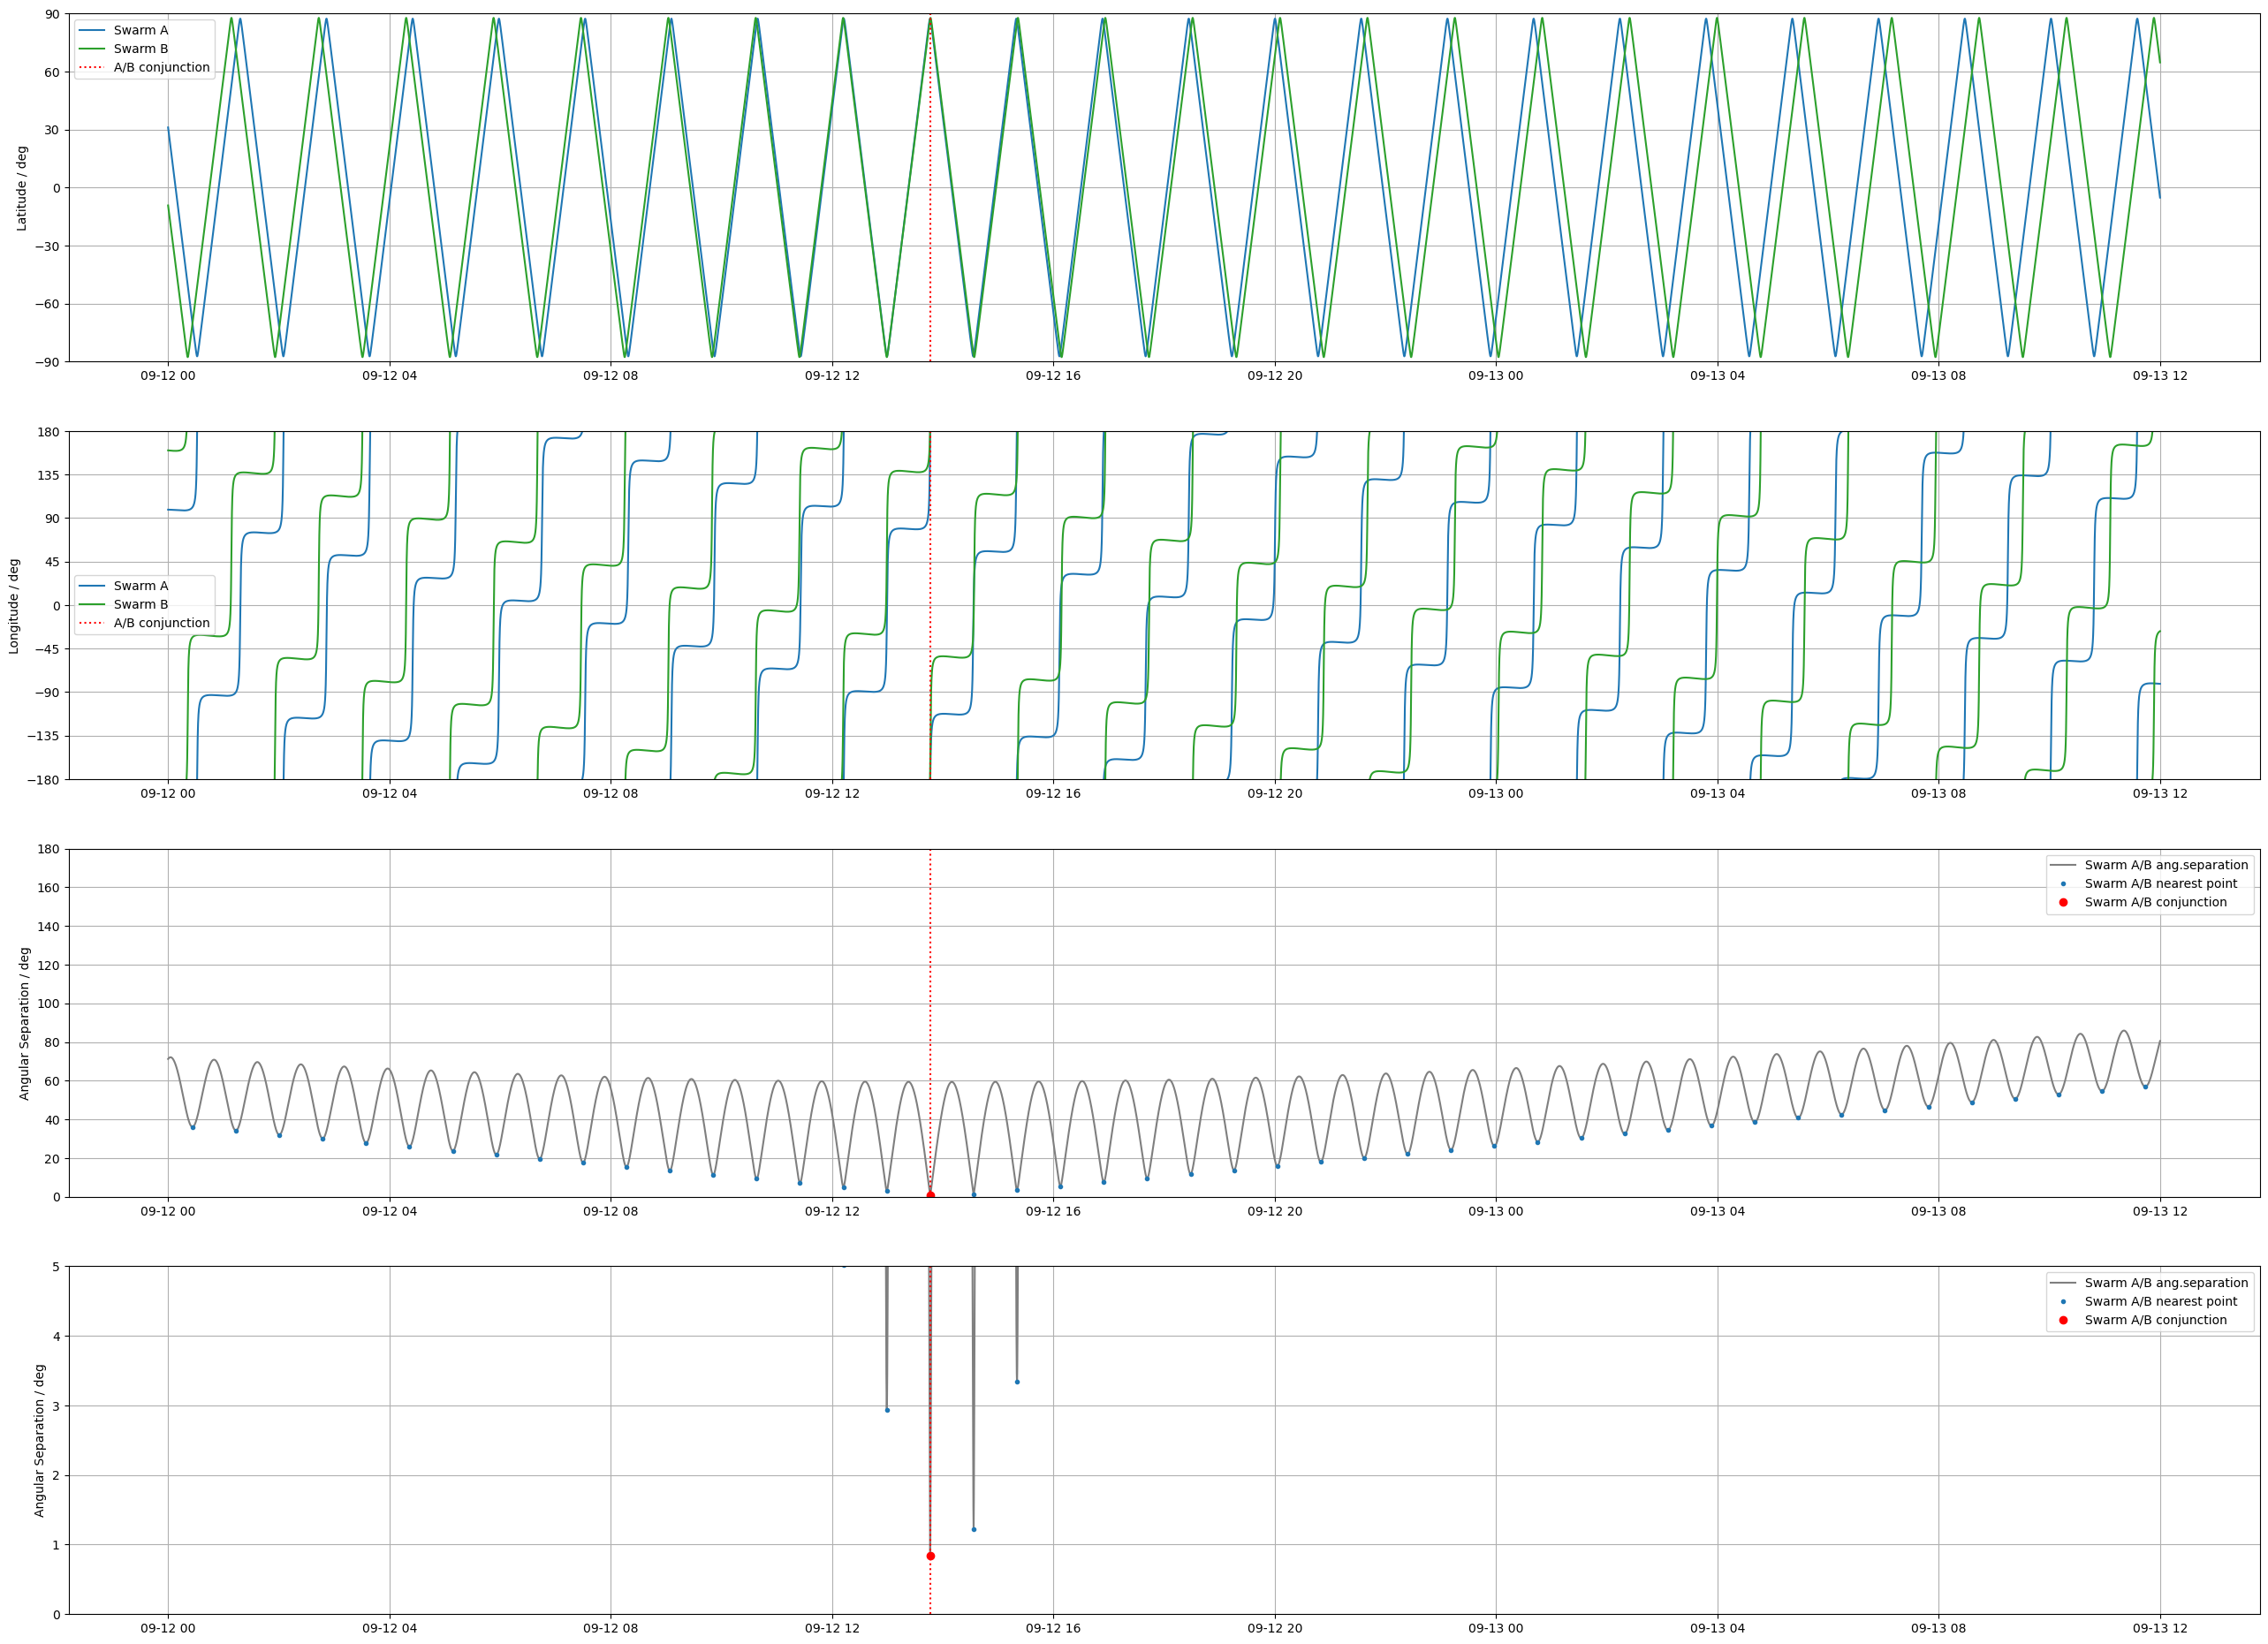

In [8]:
start_time, end_time = "2016-09-12T00:00", "2016-09-13T12:00"

conjunctions_ab = get_swarm_ab_conjunctions(start_time, end_time)
conjunctions_ab_all = get_swarm_ab_conjunctions(start_time, end_time, threshold=180.0)
orbit_a, orbit_b = get_swarm_ab_orbits(start_time, end_time, asynchronous=True)

plot_conjunctions(orbit_a, orbit_b, conjunctions_ab, conjunctions_ab_all)

Retrieving Swarm A/B conjunction times from 2014-01-28T00:00 to 2014-01-29T12:00, angular separation < 1.0 deg ... 


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.02MB)

Retrieving Swarm A/B conjunction times from 2014-01-28T00:00 to 2014-01-29T12:00, angular separation < 180.0 deg ... 


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.02MB)

Retrieving Swarm A orbit from 2014-01-28T00:00 to 2014-01-29T12:00 ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (4.281MB)

Retrieving Swarm B orbit from 2014-01-28T00:00 to 2014-01-29T12:00 ... 


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (4.281MB)

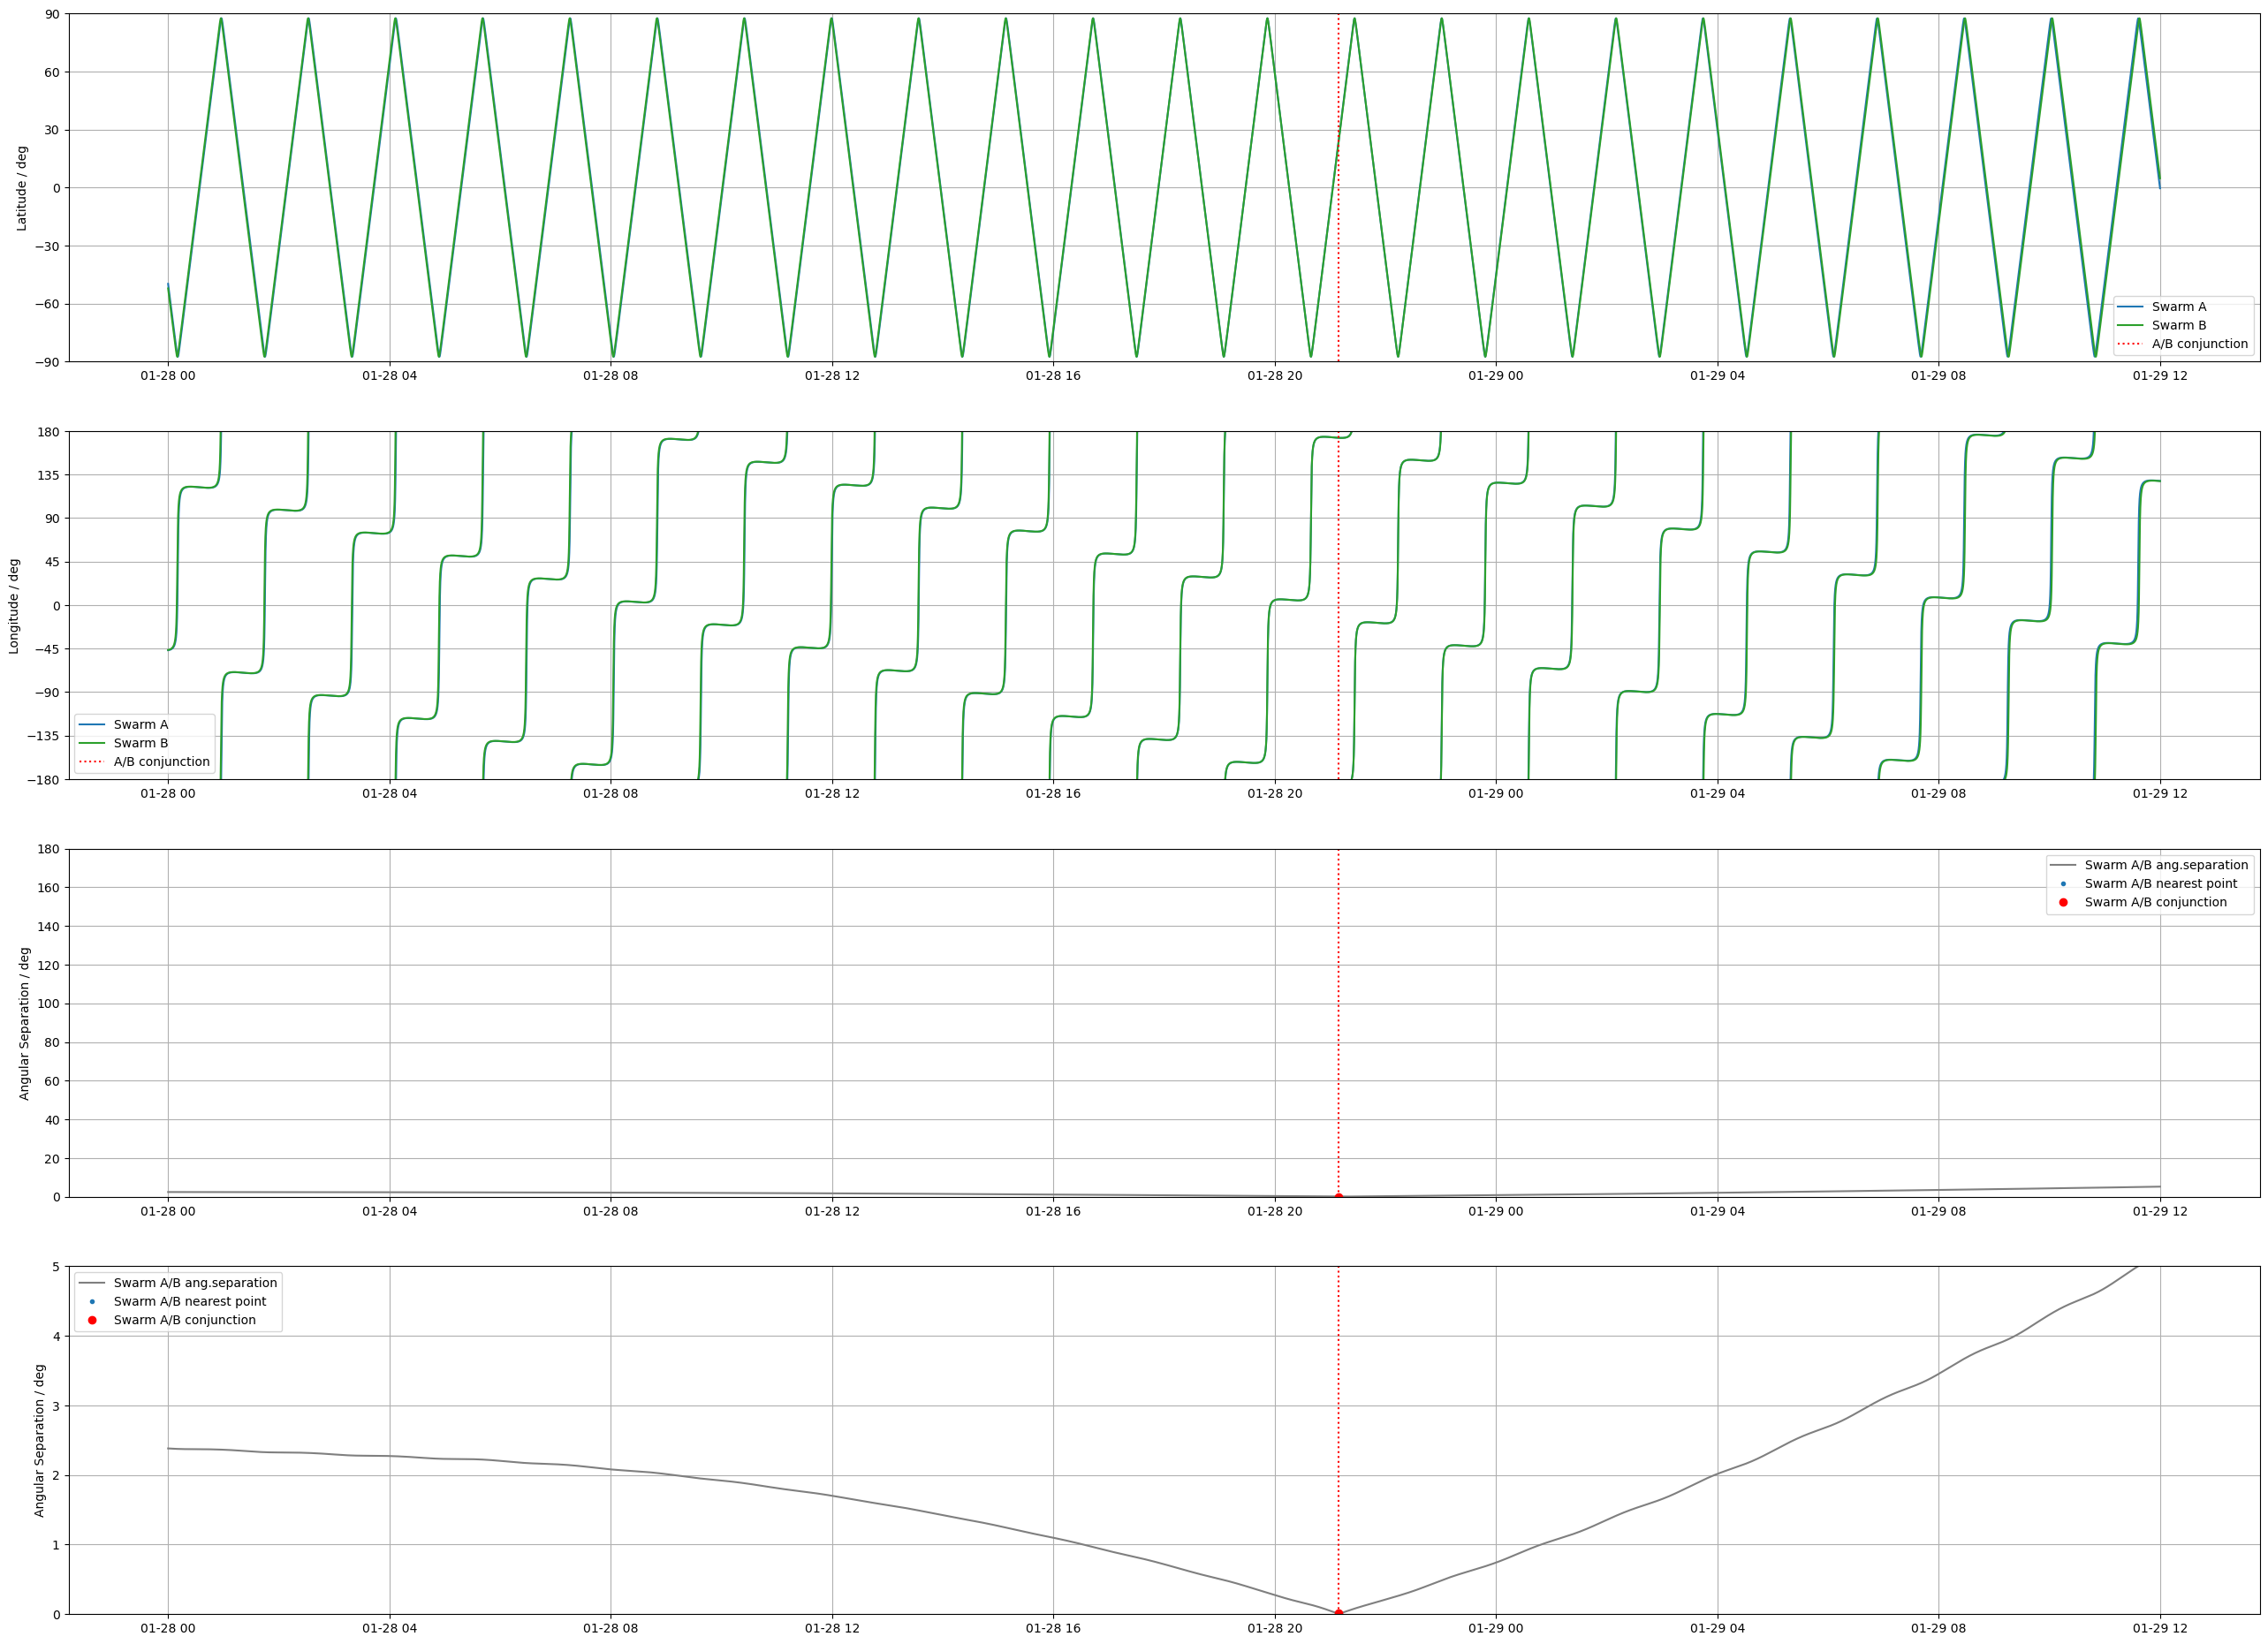

In [9]:
start_time, end_time = "2014-01-28T00:00", "2014-01-29T12:00"

conjunctions_ab = get_swarm_ab_conjunctions(start_time, end_time)
conjunctions_ab_all = get_swarm_ab_conjunctions(start_time, end_time, threshold=180.0)
orbit_a, orbit_b = get_swarm_ab_orbits(start_time, end_time, asynchronous=True)

plot_conjunctions(orbit_a, orbit_b, conjunctions_ab, conjunctions_ab_all)